In [1]:
import os
import pandas as pd
import geopandas as gpd

# Inputs
SUIT = "../data/processed/suitability_solar.parquet"   # from 06A (re-run that first!)
CANDIDATE_GEO = [
    "../data/geo/bengaluru_zones.geojson",             # preferred location
    "../data/processed/zones.geojson",                 # you have this in your repo screenshots
]

# Output
OUT_GEO_PARQUET = "../data/processed/suitability_solar_geo.parquet"
OUT_CENTROIDS   = "../data/processed/zone_centroids.parquet"

# Locate a polygon file
geo_path = None
for p in CANDIDATE_GEO:
    if os.path.exists(p):
        geo_path = p
        break

if geo_path is None:
    raise FileNotFoundError(
        "Could not find a zones GeoJSON. Put one at "
        "`data/geo/bengaluru_zones.geojson` or `data/processed/zones.geojson`."
    )

print("Using polygons:", geo_path)
print("Expecting suitability file:", SUIT)


Using polygons: ../data/processed/zones.geojson
Expecting suitability file: ../data/processed/suitability_solar.parquet


In [2]:
# Suitability (ZoneID, annual_kwh, score_0_100, score_source)
suit = pd.read_parquet(SUIT)

# Polygons (must contain ZoneID)
gdf = gpd.read_file(geo_path)

# Normalize ZoneID types (strings)
suit["ZoneID"] = suit["ZoneID"].astype(str)
gdf["ZoneID"]  = gdf["ZoneID"].astype(str)

print("Suitability rows:", suit.shape, "| Polygons:", gdf.shape)
display(suit.head(3))
display(gdf.head(2))


Suitability rows: (223, 4) | Polygons: (223, 5)


,ZoneID,annual_kwh,score_0_100,score_source
0,BLR-0001,14691.605469,0,model_pred
1,BLR-0002,14692.210938,0,model_pred
2,BLR-0003,14693.567383,0,model_pred


,ZoneID,centroid_lat,centroid_lon,Region8,geometry
0,BLR-0001,12.880317,77.476772,SW,"POLYGON ((77.47802 12.87801, 77.47775 12.87814..."
1,BLR-0002,12.898733,77.469049,SW,"POLYGON ((77.47802 12.90369, 77.47802 12.89288..."


In [3]:
merged = gdf.merge(suit, on="ZoneID", how="left")

missing = merged["annual_kwh"].isna().sum()
print(f"Zones without scores: {missing} out of {len(merged)}")

if missing > 0:
    missing_ids = merged.loc[merged["annual_kwh"].isna(), "ZoneID"].head(10).tolist()
    print("Sample missing ZoneIDs:", missing_ids)


Zones without scores: 0 out of 223


In [4]:
# Ensure WGS84 for app mapping
if merged.crs is None or merged.crs.to_epsg() != 4326:
    merged = merged.to_crs(4326)

os.makedirs(os.path.dirname(OUT_GEO_PARQUET), exist_ok=True)
merged.to_parquet(OUT_GEO_PARQUET, index=False)
print("✅ Saved:", OUT_GEO_PARQUET)

# Also export centroids (useful for nearest-zone fallback / debugging)
centroids = merged.copy()
centroids["geometry"] = centroids.geometry.centroid
centroids["lat"] = centroids.geometry.y
centroids["lon"] = centroids.geometry.x
centroids = centroids[["ZoneID","lat","lon"]]
centroids.to_parquet(OUT_CENTROIDS, index=False)
print("✅ Saved:", OUT_CENTROIDS)


✅ Saved: ../data/processed/suitability_solar_geo.parquet
✅ Saved: ../data/processed/zone_centroids.parquet


/var/folders/dy/m8k3w5n10rg7xhthbf5pxwyr0000gn/T/ipykernel_49748/762771265.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids["geometry"] = centroids.geometry.centroid


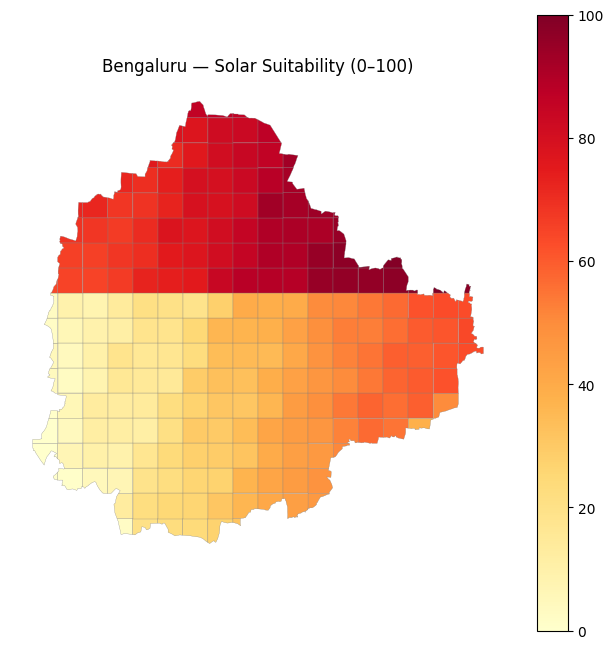

In [5]:
ax = merged.plot(column="score_0_100", cmap="YlOrRd", legend=True, figsize=(8,8), linewidth=0.2, edgecolor="grey")
ax.set_title("Bengaluru — Solar Suitability (0–100)")
ax.set_axis_off()
